# Initial test runs
This experiments seeks to test whether CALVADOS 2 is viable for simulating histone IDRs.

In [5]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append('../../src')
import data_utils
import analyse_utils

plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["font.weight"] = "normal"

## Data preparation

### Templates

In [3]:
# Defining UniProt IDs / Trivial IDs
entries = {
    'H1-0': 'P07305',
    'H2B': 'B4DR52'
}
templates = pd.DataFrame({'uniprot_id': entries.values(),
                          'name': None,
                          'description': None,
                          'species': None,
                          'sequence': None},
                          index=entries.keys())

In [53]:
# Collecting metadata
for id, row in templates.iterrows():
    name, desc, spec, seq = data_utils.get_protein_metadata(row.uniprot_id)
    templates.loc[id] = {
        'uniprot_id': row.uniprot_id,
        'name': name,
        'description': desc,
        'species': spec,
        'sequence': seq}

2it [00:00,  5.18it/s]


In [60]:
# Viewing final templates
templates

,uniprot_id,name,description,species,sequence
H1-0,P07305,H10_HUMAN,Histone H1.0,Homo sapiens (Human),MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...
H2B,B4DR52,B4DR52_HUMAN,Histone H2B,Homo sapiens (Human),MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRKESYSVYVYKVL...


In [61]:
# Saving metadata
metadata = {'templates': templates.to_dict(orient='index')}
with open('initial.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Variants

In [6]:
# Getting template metadata
with open('initial.json', 'r') as file:
    metadata = json.load(file)

In [7]:
# Getting longest IDR
length_order=True
i_idr=0

In [8]:
# Getting IDR regions
IDRs = []
for id, fields in metadata['templates'].items():
    seq, loc, reg = data_utils.get_protein_idr(uniprot_id=fields['uniprot_id'], i_idr=i_idr, length_order=length_order)
    IDRs.append({'template': id, 'sequence': seq, 'location': loc, 'region': reg})
data = pd.DataFrame(IDRs)

  0%|          | 0/2 [00:00<?, ?it/s]/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/Bio/SeqFeature.py:1940: BiopythonDeprecationWarning: Alias location.position is deprecated and will be removed in a future release. Use location directly, or int(location). However, that will fail for UnknownPosition, and for OneOfPosition and WithinPosition will give the default rather than left-most value.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


In [9]:
# Expanding dataframe to include all variants
data['variant'] = [data_utils.variant_types.keys()]*len(data)
data = data.explode('variant')
data.index = data['template'] + '_' + data['variant'].str.upper()

# Generating variant sequence
data['sequence'] = data.apply(lambda row: data_utils.generate_variant(row['sequence'], row['variant']), axis=1)

# Setting variant description
data['variant'] = data.apply(lambda row: data_utils.variant_types[row['variant']]['name'], axis=1)

In [10]:
# Viewing final data
data

,template,sequence,location,region,variant
H1-0_WT,H1-0,TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKA...,83:194,CTD,Wild type
H1-0_RAND,H1-0,SGKKSAITKPKKKASFRSKAVAPPAAKKKKSAAKKAGKLFDSKKVK...,83:194,CTD,Randomly shuffled
H1-0_CLUST,H1-0,KKKKKKKKKKRKKKRKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKA...,83:194,CTD,Terminally clustered charges
H2B_WT,H2B,MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRKE,0:36,NTD,Wild type
H2B_RAND,H2B,PTKGDPRPVGKEDSKKKAPSRKKAVKQAKAKKSMRK,0:36,NTD,Randomly shuffled
H2B_CLUST,H2B,KRKKKKRKKKKKKRKMPAVTSVQAASGPAPPGSDDE,0:36,NTD,Terminally clustered charges


In [ ]:
# Saving sequences
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Iterating over rows
for index, cols in data.iterrows():
    id = index.upper()
    desc = cols['variant']
    seq = cols['sequence']

    # Saving as FASTA format (Though one-line sequence)
    filepath = 'data/' + id + '.fasta'
    with open(filepath, 'w') as file:
        file.write('>' + id + ' ' + desc + '\n')
        file.write(seq + '\n')

In [ ]:
# Saving metadata
metadata['data'] = data.to_dict(orient='index')
with open('initial.json', 'w') as file:
    json.dump(metadata, file, indent=4)

## Analysis

In [7]:
# Loading metadata
metadata = analyse_utils.load_metadata('initial.json')
metadata = metadata.iloc[:3]
metadata

,template,sequence,location,region,variant,description,uniprot_id,name,species
H1-0_WT,H1-0,TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKA...,83:194,CTD,Wild type,Histone H1.0,P07305,H10_HUMAN,Homo sapiens (Human)
H1-0_RAND,H1-0,PGTKKPKSTKTKKALAKAKKAKVKGSKAEKATSAAKKSVKPKKSKA...,83:194,CTD,Randomly shuffled,Histone H1.0,P07305,H10_HUMAN,Homo sapiens (Human)
H1-0_CLUST,H1-0,KKKKKKKKKKRKKKKKKKKKKKKKKKKKKKKKRKKKKKKKKKKKKA...,83:194,CTD,Terminally clustered charges,Histone H1.0,P07305,H10_HUMAN,Homo sapiens (Human)


In [8]:
# Loading trajectories
metadata['traj'] = metadata.apply(lambda row: md.load_dcd(*['/'.join(['results', row.name, filename]) for filename  in ['traj.dcd', 'top.pdb']]), axis=1)

### Composition

In [5]:
# Calculating amino acid compositions
freqs = analyse_utils.amino_acid_content(metadata.sequence)

/tmp/ipykernel_12107/3657817101.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  patches, texts, autotexts  = ax.pie(data, autopct='%1.1f%%', labels=data.index, startangle=90, colors=get_cmap('Reds_r')(np.linspace(0,1,len(data))))


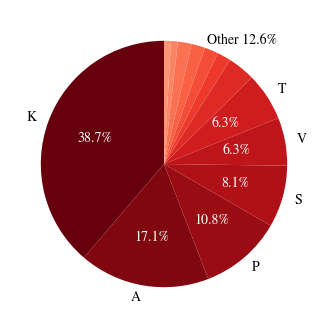

In [7]:
# Plotting distributions for H1.0
from matplotlib.cm import get_cmap
fig, ax = plt.subplots(figsize=(4, 4))
data = freqs.loc['H1-0_WT'].sort_values(ascending=False)
patches, texts, autotexts  = ax.pie(data, autopct='%1.1f%%', labels=data.index, startangle=90, colors=get_cmap('Reds_r')(np.linspace(0,1,len(data))))

other = []
for f, text, autotext in zip(data, texts, autotexts):
    autotext.set_color('white')
    if f < 0.05:
        text.set_visible(False)
        autotext.set_visible(False)
        other.append((f, text, autotext))

other_x = (other[0][1].get_position()[0] + other[-1][1].get_position()[0])/2
other_y = (other[0][1].get_position()[1] + other[-1][1].get_position()[1])/2
other_pct = sum([float(aa[2].get_text()[:-1])/100 for aa in other])
ax.text(other_x, other_y, f"Other {other_pct:.1%}")

fig.savefig("human_h1.0_composition.png")

#ax.set_title("Amino acid composition", fontweight='bold')

In [19]:
111 * freqs.astype(float)

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
H1-0_WT,19.000000,0.0,1.000000,2.000000,2.0,4.000000,0.0,1.0,43.000000,2.0,0.000000,0.0,12.000000,0.000000,2.000000,9.000000,7.000000,7.000000,0.0,0.0
H1-0_RAND,19.000000,0.0,1.000000,2.000000,2.0,4.000000,0.0,1.0,43.000000,2.0,0.000000,0.0,12.000000,0.000000,2.000000,9.000000,7.000000,7.000000,0.0,0.0
H1-0_CLUST,19.000000,0.0,1.000000,2.000000,2.0,4.000000,0.0,1.0,43.000000,2.0,0.000000,0.0,12.000000,0.000000,2.000000,9.000000,7.000000,7.000000,0.0,0.0
H2B_WT,12.685714,0.0,6.342857,0.000000,0.0,6.342857,0.0,0.0,38.057143,0.0,3.171429,0.0,12.685714,3.171429,9.514286,9.514286,3.171429,6.342857,0.0,0.0
H2B_RAND,15.857143,0.0,3.171429,3.171429,0.0,6.342857,0.0,0.0,38.057143,0.0,3.171429,0.0,12.685714,3.171429,9.514286,9.514286,3.171429,3.171429,0.0,0.0
H2B_CLUST,15.857143,0.0,3.171429,3.171429,0.0,6.342857,0.0,0.0,38.057143,0.0,3.171429,0.0,12.685714,3.171429,9.514286,9.514286,3.171429,3.171429,0.0,0.0


### CIDER parameters

More on CIDER from Pappu Lab:
- [CIDER](http://pappulab.wustl.edu/CIDER/about/)
- [localCIDER](http://pappulab.github.io/localCIDER/)

In [4]:
# Calculating parameters
cider = analyse_utils.cider_parameters(metadata['sequence'])
cider['Length'] = metadata.sequence.str.len()
cider['Charge'] = (cider.Length * cider.NCPR).astype(int)

cider

,kappa,FCR,NCPR,Hydrophobicity,Frac. dis. prom.,Length,Charge
H1-0_WT,0.154432,0.432432,0.378378,3.24955,0.891892,111,42
H1-0_RAND,0.217323,0.432432,0.378378,3.24955,0.891892,111,42
H1-0_CLUST,0.994959,0.432432,0.378378,3.24955,0.891892,111,42


### Structural descriptors

In [13]:
struc = pd.DataFrame(index=metadata.index)

In [14]:
# Computing radius of gyration
struc['Rg'] = metadata.apply(lambda row: analyse_utils.compute_rg(row.traj), axis=1)
struc['<Rg>'] = struc.apply(lambda row: row.Rg.mean(), axis=1)
struc['std(Rg)'] = struc.apply(lambda row: row.Rg.std(), axis=1)

In [15]:
# Computing end-to-end distance
struc['Re'] = metadata.apply(lambda row: analyse_utils.compute_end_to_end(row.traj), axis=1)
struc['<Re>'] = struc.apply(lambda row: row.Re.mean(), axis=1)
struc['std(Re)'] = struc.apply(lambda row: row.Re.std(), axis=1)

In [18]:
# Computing asphericity
struc['Delta'] = metadata.apply(lambda row: analyse_utils.compute_asphericity(row.traj), axis=1)

In [19]:
# Computing prolateness
struc['S'] = metadata.apply(lambda row: analyse_utils.compute_prolateness(row.traj), axis=1)

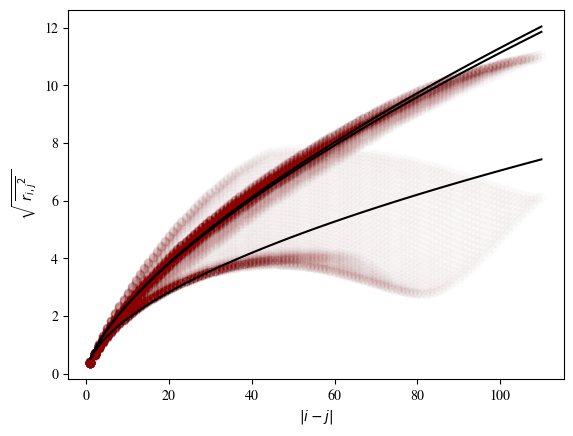

In [20]:
# Computing scaling exponent
struc['v'] = metadata.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj, plot=True, ij_cutoff=10)[0], axis=1)

In [22]:
# Displaying means
struc

,Rg,<Rg>,std(Rg),Re,<Re>,std(Re),Delta,S,v
H1-0_WT,"[3.421810885217283, 3.3894537519318484, 3.5202...",4.238425,0.729989,"[[6.1385975], [8.097507], [8.866052], [6.82381...",10.551771,3.399789,0.268711,1.413245,0.669331
H1-0_RAND,"[5.7079746902826605, 4.858863350320392, 4.3030...",4.192114,0.721043,"[[16.615564], [13.207169], [12.061758], [10.71...",10.438379,3.369846,0.268620,1.377144,0.666044
H1-0_CLUST,"[2.336893665017183, 2.843818060461379, 3.29166...",2.984825,0.508966,"[[3.4367023], [4.554394], [7.152094], [7.60118...",5.642762,2.410603,0.218788,1.198941,0.566684


<Figure size 800x500 with 0 Axes>

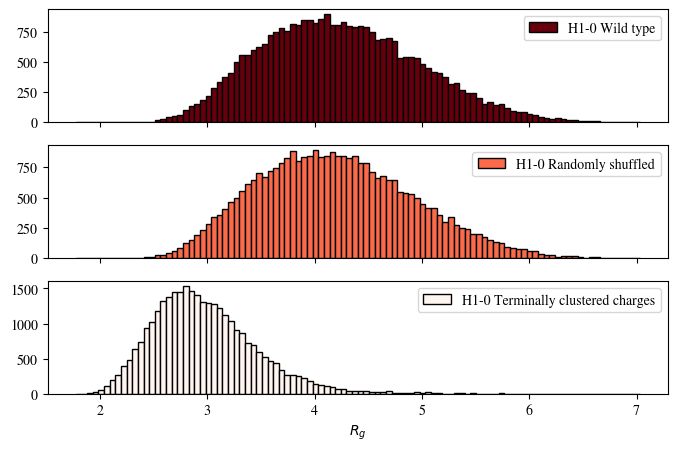

In [14]:
# Plotting distributions
measure = 'Rg'
plt.figure(figsize=(8,5))
axes = struc[[measure]].transpose().explode([*struc.index]).astype(float).plot.hist(bins=100, subplots=True, figsize=(8,5), cmap="Reds_r", edgecolor='black')
for i, ax in enumerate(axes):
    ax.set_ylabel(None)
    ax.legend([(metadata.template + ' ' + metadata.variant)[i]])
    if i == len(axes) - 1:
        ax.set_xlabel("$R_g$")

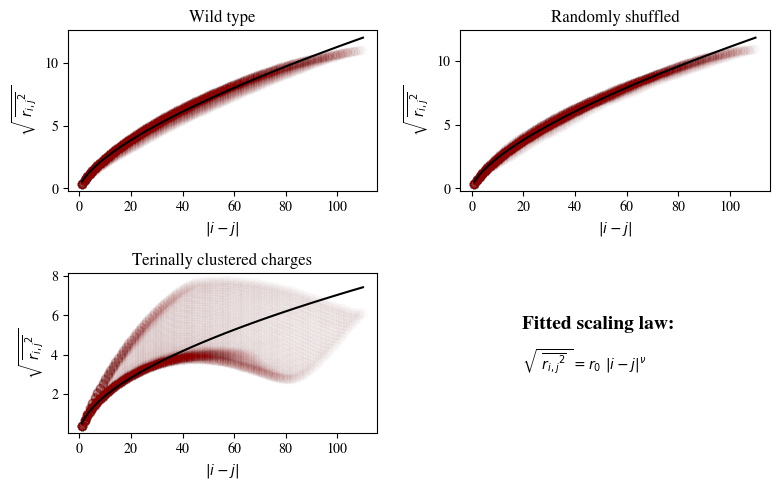

In [4]:
plt.figure(figsize=(8,5))
plt.subplot(221)
analyse_utils.compute_scaling_exponent(metadata.iloc[0].traj, plot=True, ij_cutoff=10)
plt.title("Wild type")

plt.subplot(222)
analyse_utils.compute_scaling_exponent(metadata.iloc[1].traj, plot=True, ij_cutoff=10)
plt.title("Randomly shuffled")

plt.subplot(223)
analyse_utils.compute_scaling_exponent(metadata.iloc[2].traj, plot=True, ij_cutoff=10)
plt.title("Terinally clustered charges")

plt.subplot(224)
plt.axis('off')
plt.text(0.2,0.65,"Fitted scaling law:", fontweight='bold', fontsize=14)
plt.text(0.2,0.4,"\n$\sqrt{\ \overline{{r_{i,j}}^2}\ } = r_0\ {|i-j|}^{\\nu}$", fontsize=10)

plt.tight_layout()

### Contact maps

In [ ]:
# Choosing single variant as example
example = metadata.loc['H1-0_WT']

In [17]:
# Calculating distances
pairs = example.traj.top.select_pairs('all', 'all')
distances = md.geometry.squareform(md.compute_distances(example.traj, pairs), pairs)

/tmp/ipykernel_25346/2519477321.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(distances.mean(axis=0), cmap=plt.cm.get_cmap('Reds_r'))


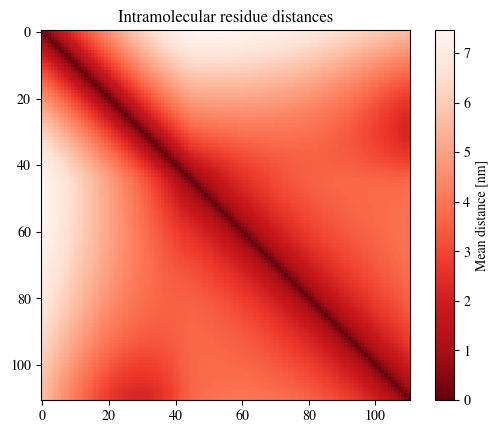

In [18]:
# Plotting distance contact map
plt.imshow(distances.mean(axis=0), cmap=plt.cm.get_cmap('Reds_r'))
plt.title("Intramolecular residue distances")
plt.colorbar(label="Mean distance [nm]")

In [11]:
# Calculating interaction energies
pairs = example.traj.top.select_pairs('all', 'all')
ah, dh = analyse_utils.compute_energy(example.traj)
ah = md.geometry.squareform(ah, pairs)
dh = md.geometry.squareform(dh, pairs)
tot = ah + dh

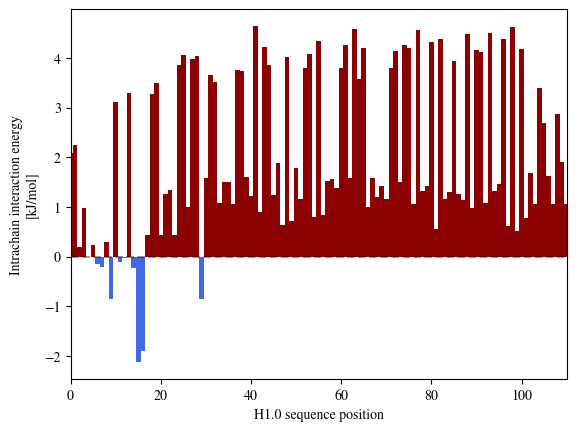

In [12]:
# Calculating energy per residue
res_energy = tot.mean(axis=0).sum(axis=(1))
plt.bar(range(111), np.where(res_energy>0, res_energy, 0), width=1, color='darkred')
plt.bar(range(111), np.where(res_energy<0, res_energy, 0), width=1, color='royalblue')
plt.xlabel("H1.0 sequence position")
plt.ylabel("Intrachain interaction energy\n[kJ/mol]")
plt.hlines(0,*plt.xlim(0,110), color='k', alpha=0.4, linestyles='--')

/tmp/ipykernel_25346/3241906960.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(ah.mean(axis=0)*1000, vmin=-10, vmax=10, cmap=plt.cm.get_cmap('coolwarm'))


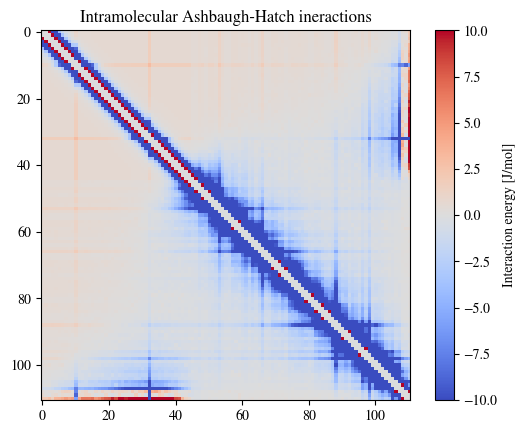

/tmp/ipykernel_25346/3241906960.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(dh.mean(axis=0)*1000, vmin=-10, vmax=10, cmap=plt.cm.get_cmap('coolwarm'))


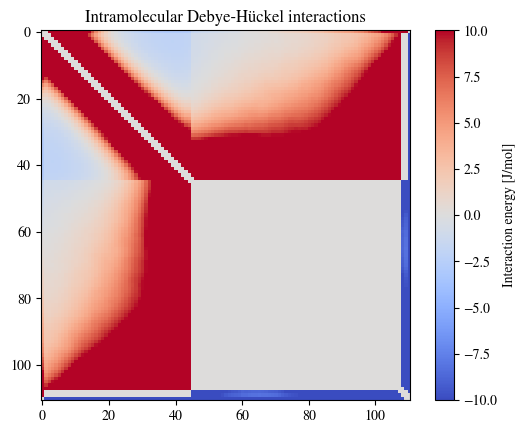

/tmp/ipykernel_25346/3241906960.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(tot.mean(axis=0)*1000, vmin=-10, vmax=10, cmap=plt.cm.get_cmap('coolwarm'))


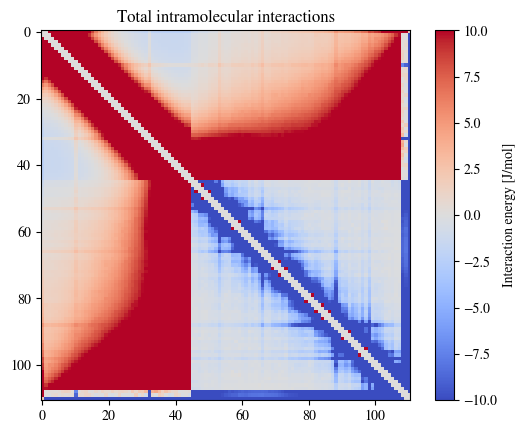

In [20]:
# Plotting energy contact maps
plt.imshow(ah.mean(axis=0)*1000, vmin=-10, vmax=10, cmap=plt.cm.get_cmap('coolwarm'))
plt.title("Intramolecular Ashbaugh-Hatch ineractions")
plt.colorbar(label="Interaction energy [J/mol]")
plt.show()

plt.imshow(dh.mean(axis=0)*1000, vmin=-10, vmax=10, cmap=plt.cm.get_cmap('coolwarm'))
plt.title("Intramolecular Debye-Hückel interactions")
plt.colorbar(label="Interaction energy [J/mol]")
plt.show()

plt.imshow(tot.mean(axis=0)*1000, vmin=-10, vmax=10, cmap=plt.cm.get_cmap('coolwarm'))
plt.title("Total intramolecular interactions")
plt.colorbar(label="Interaction energy [J/mol]")
plt.show()

/tmp/ipykernel_25346/2325913445.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(distances.mean(axis=0), cmap=plt.cm.get_cmap('Reds_r'))
/tmp/ipykernel_25346/2325913445.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(ah.mean(axis=0)*1000, vmin=-10, vmax=10, cmap=plt.cm.get_cmap('coolwarm'))
/tmp/ipykernel_25346/2325913445.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(dh.mean(axis=0)*1000, vmin=-10, vmax=10, cmap=plt.cm.get_cmap('

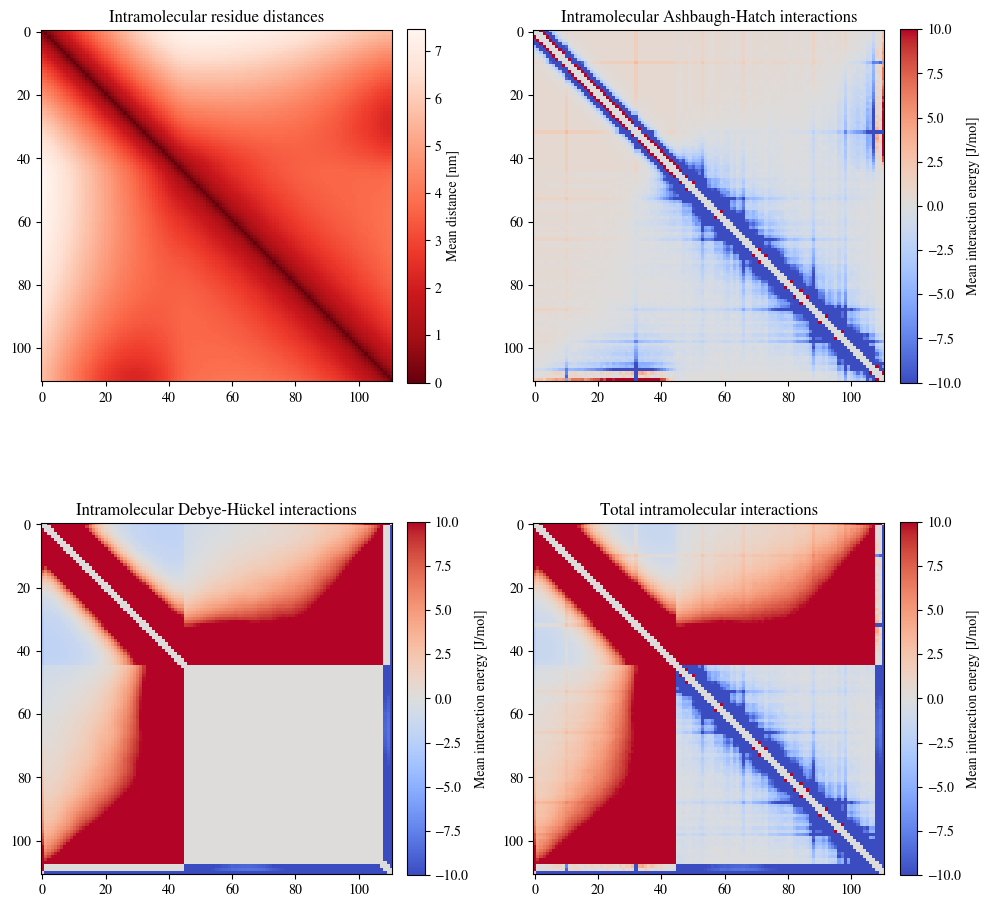

In [21]:
# Combined plot
plt.figure(figsize=(10,10))

plt.subplot(221)
plt.imshow(distances.mean(axis=0), cmap=plt.cm.get_cmap('Reds_r'))
plt.title("Intramolecular residue distances")
plt.colorbar(label="Mean distance [nm]", fraction=0.046, pad=0.04)

plt.subplot(222)
plt.imshow(ah.mean(axis=0)*1000, vmin=-10, vmax=10, cmap=plt.cm.get_cmap('coolwarm'))
plt.title("Intramolecular Ashbaugh-Hatch interactions")
plt.colorbar(label="Mean interaction energy [J/mol]", fraction=0.046, pad=0.04)

plt.subplot(223)
plt.imshow(dh.mean(axis=0)*1000, vmin=-10, vmax=10, cmap=plt.cm.get_cmap('coolwarm'))
plt.title("Intramolecular Debye-Hückel interactions")
plt.colorbar(label="Mean interaction energy [J/mol]", fraction=0.046, pad=0.04)

plt.subplot(224)
plt.imshow(tot.mean(axis=0)*1000, vmin=-10, vmax=10, cmap=plt.cm.get_cmap('coolwarm'))
plt.title("Total intramolecular interactions")
plt.colorbar(label="Mean interaction energy [J/mol]", fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Drawing sequence

In [180]:
# Mapping sequence by charge
mapseq = []
for aa in example.sequence:
    if aa in ['D', 'E']:
        mapseq.append(-1)
    elif aa in ['K', 'R']:
        mapseq.append(1)
    else:
        mapseq.append(0)

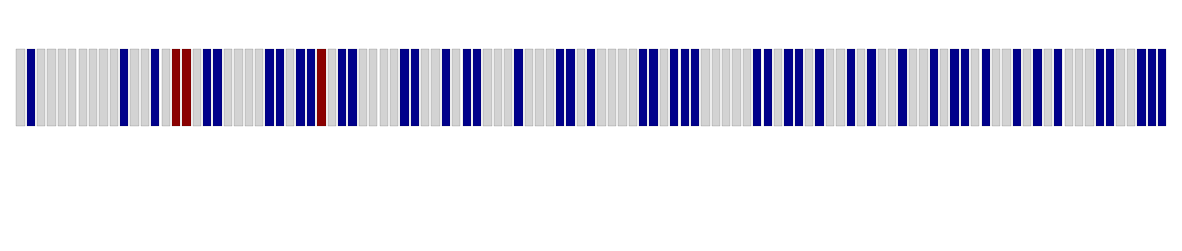

In [188]:
# Create a figure and axes object
fig, ax = plt.subplots(figsize=(15,3))

# Set the axis limits
ax.set_xlim([-1, len(mapseq)])
ax.set_ylim([-1.5, 1.5])

# Loop over the numbers and plot them as vertical bars
for i, num in enumerate(mapseq):
    color = {-1: 'darkred', 0: 'lightgrey', 1: 'darkblue'}[num]
    ax.bar(i, 1, color=color, edgecolor='black', linewidth=0.1,)

# Hide the ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Show the plot
plt.show()

### RMSF

In [7]:
# Choosing single variant as example
example = metadata.loc['H1-0_CLUST']

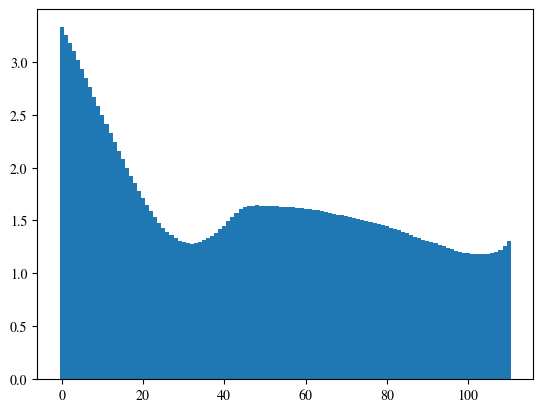

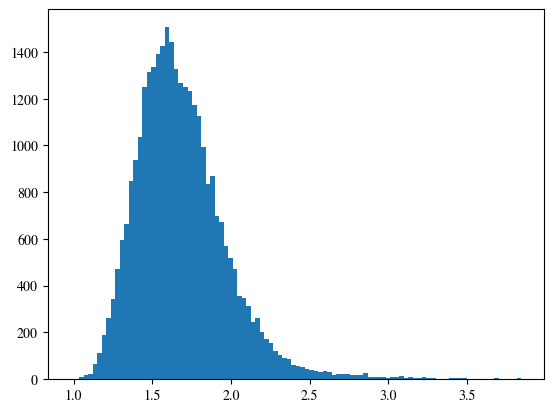

In [8]:
traj = example.traj
ref = traj.xyz.mean(axis=0)
rmsf_time = np.sqrt(np.square(traj.xyz - ref).mean(axis=(1,2)))
rmsf_pos = np.sqrt(np.square(traj.xyz - ref).mean(axis=(0,2)))

plt.bar(range(111), rmsf_pos, width=1)
plt.show()

plt.hist(rmsf_time, bins=100)
plt.show()

### Drawing sequence

In [4]:
seq = metadata.loc['H1-0_WT'].sequence
H10 = (1,194)
NTD_IDR = (1,29)
H15 = (24,97)
CTD_IDR = (121,194)

In [37]:
seq = metadata.loc['H1-0_WT'].sequence

In [42]:
seq

'TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKAASKAPTKKPKATPVKKAKKKLAATPKKAKKPKTVKAKPVKASKPKKAKPVKPKAKSSAKRAGKKK'

In [46]:
# Finding motifs

# Phosphorylation by CDK: S/T-P-X-K/R motif
CDK_motifs = []
for i in range(len(seq)-3):
    m = seq[i:i+3+1]
    
    if not m[0] in ['S', 'T']:
        continue

    if not m[1] == 'P':
        continue

    if not m[3] in ['K', 'R']:
        continue

    CDK_motifs.append((i, i+3))

print(CDK_motifs)

[(35, 38), (57, 60), (69, 72)]


In [55]:
# Lysine doublets
n_K = 0
n_dK = 0
for i, aa in enumerate(seq):
    if aa != 'K':
        continue
    n_K += 1
    if seq[i-1]=='K' or seq[i+1]=='K':
        n_dK += 1
print(n_dK/n_K)

0.6511627906976745


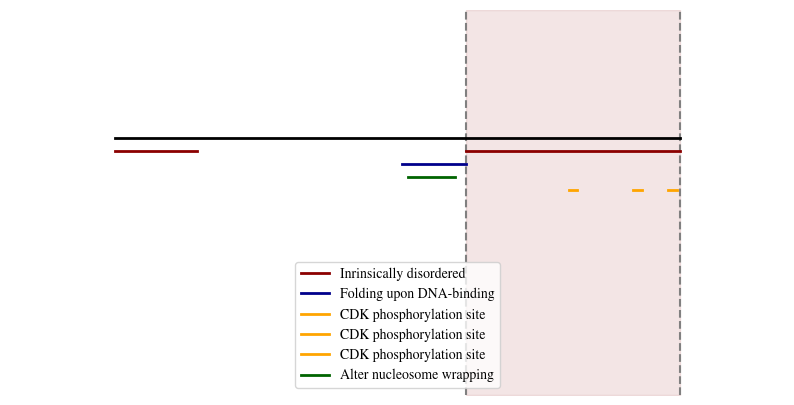

In [65]:
plt.figure(figsize=(10,5))
plt.xlim(-35,230)
plt.ylim(20,-10)
plt.axis('off')

# Area of interest
plt.vlines(CTD_IDR, *plt.ylim(), linestyles='--', color='grey')
plt.fill_betweenx(plt.ylim(),(CTD_IDR[0],CTD_IDR[0]), (CTD_IDR[1],CTD_IDR[1]), color='darkred', alpha=0.1)

# Full length
plt.plot(H10, (0,0), linewidth=2, color='black')

# IDR
plt.plot(NTD_IDR, (1,1), linewidth=2, color='darkred', label='Inrinsically disordered')
plt.plot(CTD_IDR, (1,1), linewidth=2, color='darkred')

# Folding upon DNA binding
plt.plot((99,121), (2,2), linewidth=2, color='darkblue', label='Folding upon DNA-binding')

# Motifs
for m in CDK_motifs:
    plt.plot([i+CTD_IDR[0] for i in m], (4,4), linewidth=2, color='orange', label='CDK phosphorylation site')

# Small Region of the H1.0 CTD Is Largely Responsible for Altering Nucleosome Wrapping and Subsequent TF Binding
plt.plot((101,117), (3,3), linewidth=2, color='darkgreen', label='Alter nucleosome wrapping')

plt.legend(loc='lower center')

In [54]:
for m in CDK_motifs:
    print([i+CTD_IDR[0] for i in m])

[156, 159]
[178, 181]
[190, 193]
